In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

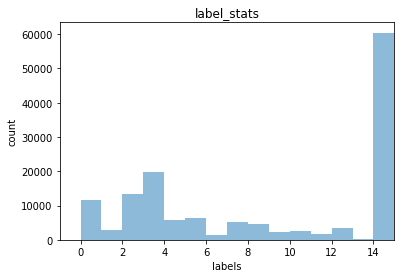

15
tensor([  8.7200,  39.4473,   7.4256,   4.6427,  18.5127,  16.7321,  81.8677,
         20.1627,  23.0240,  47.6843,  43.5628,  65.5006,  32.1226, 492.9207],
       device='cuda:0')


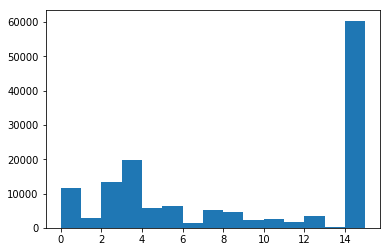

In [2]:

import torch
import os
from PIL import Image
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F 


image_info = pd.read_csv("/datasets/ChestXray-NIHCC/Data_Entry_2017.csv")
labels = image_info["Finding Labels"]
classes = {0: "Atelectasis", 1: "Cardiomegaly", 2: "Effusion", 
                3: "Infiltration", 4: "Mass", 5: "Nodule", 6: "Pneumonia", 
                7: "Pneumothorax", 8: "Consolidation", 9: "Edema", 
                10: "Emphysema", 11: "Fibrosis", 
                12: "Pleural_Thickening", 13: "Hernia",14:"No Finding" }
class_label  = {v: k for k, v in classes.items()}
label_stats = []
for l in labels: 
    l_list = l.split('|')
    
    for z in l_list:
        label_stats.append(class_label[z])

data = label_stats

# fixed bin size
bins = np.arange(0, 16, 1) # fixed bin size

plt.xlim([min(data)-1, max(data)+1])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('label_stats')
plt.xlabel('labels'"")
plt.ylabel('count')

plt.show()

counts, b, bars = plt.hist(data,bins=bins)
print(len(counts))
# print((counts))
minus_counts = 112120 - counts
# print(minus_counts)

weight_bce = minus_counts/counts
# print(weight_bce)
ratio = 1.0*counts/sum(counts)

weight_bce = weight_bce[0:-1]
# print(weight_bce.shape)
weight_temp = np.ones((len(weight_bce)))
# print(weight_bce)
# weight = np.c_[weight_temp, weight_bce]

# print(weight)

# weight_bce = (ratio[-1]/ratio)[0:-1]
# print(weight_bce)
# print(weight_bce)

weight_bce = torch.from_numpy(np.array(weight_bce)).type(torch.cuda.FloatTensor)
print(weight_bce)


In [3]:
import torchvision.models as models
model = models.resnet34(pretrained=True)
model.fc = nn.Sequential(nn.Linear(512, 14))

In [4]:
ct = 0
for child in model.children():
    ct += 1
    if ct < 9:
        for param in child.parameters():
            param.requires_grad = False

In [ ]:
from baseline_cnn import *


# Setup: initialize the hyperparameters/variables
# Setup: initialize the hyperparameters/variables
num_epochs = 10           # Number of full passes through the dataset
batch_size = 128          # Number of samples in each minibatch
learning_rate = 0.001  
seed = np.random.seed(1) # Seed the random number generator for reproducibility
p_val = 0.1              # Percent of the overall dataset to reserve for validation
p_test = 0.2             # Percent of the overall dataset to reserve for testing


#TODO: Convert to Tensor - you can later add other transformations, such as Scaling here

transform = transforms.Compose([
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

model = model
model = model.to(computing_device)
    
# Setup the training, validation, and testing dataloaders
train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)

criterion = nn.BCEWithLogitsLoss(pos_weight = weight_bce)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

CUDA is supported


In [ ]:
print("Model on CUDA?", next(model.parameters()).is_cuda)

Model on CUDA? True


In [ ]:
import torch.nn.functional as F

In [ ]:
import numpy as np
# label = np.asarray([[1, 0, 0], [0, 1, 1], [0, 1, 1]])
# output = np.asarray([[0, 0.9, 0], [0, 0.9, 0], [0.9, 0, 0.6]])
def prediction(labels, outputs):
    threshold = 0.5
    num_cor = 0
    num_tp = 0
    num_fp = 0
    num_fn = 0
    num_total = labels.shape[0]*labels.shape[1]
    test_result = np.zeros((labels.shape))
    
    temp_position = np.where(outputs >= threshold)
    
    test_result[temp_position] = 1
        
    temp_position0 = np.array(np.where(test_result == 1.0)).T.tolist()
    temp_position1 = np.array(np.where(labels == 1)).T.tolist()
          
    temp_position2 = np.array(np.where(test_result == 0.0)).T.tolist()
    temp_position3 = np.array(np.where(labels == 0)).T.tolist()
    
    temp_position4 = np.array(np.where(labels == test_result)).T.tolist()
    
    
    num_cor = len(temp_position4)
    for element in temp_position0:
        if element in temp_position1:
            num_tp += 1
    
    for element in temp_position0:
        if element in temp_position3:
            num_fp += 1   
    
    for element in temp_position2:
        if element in temp_position1:
            num_fn += 1      
            
    print(num_cor)
    
    accuracy = num_cor/num_total
    if num_fp + num_tp == 0:
        precision = 0
    else:
        precision = num_tp/(num_fp + num_tp)
    if num_tp + num_fn == 0:
        recall = 0
    else:
        recall = num_tp/(num_tp + num_fn)
    bcr = (precision + recall)/2
    return accuracy, precision, recall, bcr

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(train_loader, 0):
                inputs = torch.squeeze(torch.stack([inputs,inputs,inputs], dim=1, out=None))
                inputs = inputs.to(computing_device)
                #zeros = torch.zeros([batch_size, 986])
                #labels = torch.cat((labels,zeros), 1)
                labels = labels.to(computing_device)
                
                #print(labels.shape)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #running_corrects += torch.sum(preds == labels.data)
                running_corrects = 0
                output_np = torch.sigmoid(outputs).cpu().detach().numpy()
                label_np = labels.cpu().detach().numpy()
                accuracy, precision, recall, bcr = prediction(label_np, output_np)
                print('accuracy, precision, recall', accuracy, precision, recall)
                print("Loss is ",loss.item())
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_trained = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
764
accuracy, precision, recall 0.4263392857142857 0.03721841332027424 0.4578313253012048
Loss is  1.2390117645263672
824
accuracy, precision, recall 0.45982142857142855 0.05263157894736842 0.6190476190476191
Loss is  1.3361408710479736
816
accuracy, precision, recall 0.45535714285714285 0.05740181268882175 0.5876288659793815
Loss is  1.378330111503601
820
accuracy, precision, recall 0.4575892857142857 0.046583850931677016 0.46875
Loss is  1.3992644548416138
845
accuracy, precision, recall 0.47154017857142855 0.06190975865687303 0.5267857142857143
Loss is  1.4761631488800049
836
accuracy, precision, recall 0.46651785714285715 0.05345911949685535 0.49038461538461536
Loss is  1.3637497425079346
858
accuracy, precision, recall 0.47879464285714285 0.0574468085106383 0.5294117647058824
Loss is  1.4478956460952759
845
accuracy, precision, recall 0.47154017857142855 0.05152471083070452 0.5212765957446809
Loss is  1.2572377920150757
847
accuracy, precision, recall 0.47265